<a href="https://colab.research.google.com/github/nataliarestrada/IPDI-Estrada/blob/main/PDI_TP04_Estrada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Trabajo Practico N°4 - Procesamiento por Convolución
Asignatura: **Introducción al Procesamiento Digital de Imágenes (PDI)**

Alumno: **Natalia R. Estrada** - email: nataliarominaestrada@gmail.com

La actividad propuesta: Implementar un aplicativo que levante una imagen en nivel de gris (o que la convierta a YIQ y retenga solo el Y) y aplique el filtrado por convolución para los siguientes filtros:
1. Pasabajos: Plano y Bartlett 3x3, 5x5, 7x7. Gaussiano 5x5 y 7x7.
2. Detectores de bordes: Laplaciano v4 y v8. Sobel las 8 orientaciones.
3. Pasabanda, pasaaltos de frecuencia de corte 0,2 y 0,4




####Desarrollo
Importamos las librerias necesarias

In [1]:
import os
import numpy as np
import imageio as io
import matplotlib.pyplot as plt
from google.colab import files

Funciones necesarias para realizar las operaciones

In [2]:
#Función para pasar de RGB a escala de grises
def rgb_to_gray(rgb):
  r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
  gray = 0.299 * r + 0.587 * g + 0.114 * b
  return gray

#Función para convertir una imagen del espacio RGB al YIQ
def rgb_to_yiq(RGB):
    '''
    input: matriz de la imagen en formato RGB normalizada
    output: matriz de la imagen en formato YIQ
    '''
    rgb2yiq_matrix = np.array([[0.299,0.587,0.114],[0.595716,-0.274453,-0.321263],[0.211456,-0.522591,0.311135]])
    #print("Matriz de conversion RGB a YIQ:")
    #print(rgb2yiq_matrix)

    #Se normalizan los valores de RGB entre 0.0 y 1.0
    RGB = RGB/255 

    Y = rgb2yiq_matrix[0][0] * RGB[:,:,0] + rgb2yiq_matrix[0][1] * RGB[:,:,1] + rgb2yiq_matrix[0][2] * RGB[:,:,2]
    I = rgb2yiq_matrix[1][0] * RGB[:,:,0] + rgb2yiq_matrix[1][1] * RGB[:,:,1] + rgb2yiq_matrix[1][2] * RGB[:,:,2]
    Q = rgb2yiq_matrix[2][0] * RGB[:,:,0] + rgb2yiq_matrix[2][1] * RGB[:,:,1] + rgb2yiq_matrix[2][2] * RGB[:,:,2]

    Y = np.clip(Y, 0, 1)
    I = np.clip(I, -0.5957, 0.5957)
    Q = np.clip(Q, -0.5226, 0.5226)
    
    YIQ = np.dstack((Y,I,Q))
    
    return YIQ

#Función para convertir una imagen del espacio YIQ al RGB 
def yiq_to_rgb(YIQ):
    '''
    input: matriz de la imagen en formato YIQ 
    output: matriz de la imagen en formato RGB (en bytes)
    '''
    yiq2rgb_matrix = np.array([[1,0.9663,0.6210],[1,-0.2721,-0.6474],[1,-1.1070,1.7046]])
    #print("Matriz de conversion YIQ a RGB:")
    #print(yiq2rgb_matrix)

    R = yiq2rgb_matrix[0][0] * YIQ[:,:,0] + yiq2rgb_matrix[0][1] * YIQ[:,:,1] + yiq2rgb_matrix[0][2] * YIQ[:,:,2]
    G = yiq2rgb_matrix[1][0] * YIQ[:,:,0] + yiq2rgb_matrix[1][1] * YIQ[:,:,1] + yiq2rgb_matrix[1][2] * YIQ[:,:,2]
    B = yiq2rgb_matrix[2][0] * YIQ[:,:,0] + yiq2rgb_matrix[2][1] * YIQ[:,:,1] + yiq2rgb_matrix[2][2] * YIQ[:,:,2]

    #Se controla que no haya pixeles con valores menores a 0 y mayores a 1 (Dadas las multiplicaciones y sumas realizadas,
    #puede ocurrir que un valor exceda un poco el límite de 255 o sea ligeramente menor a 0 ocasionando errores en la visualización)
    R = np.clip(R, 0, 1)
    G = np.clip(G, 0, 1)
    B = np.clip(B, 0, 1)

    #Se convierten los valores a byte (valores enteros de 0 a 255)
    R = (R*255).astype(int)
    G = (G*255).astype(int)
    B = (B*255).astype(int)    
    
    RGB = np.dstack((R,G,B))
    
    return RGB

#Función para plotear dos imágenes
def plot_2images(image, title_1, image_mod, title_2, figsize=(17,7)):
  fig, axs = plt.subplots(1,2,figsize=figsize)

  plt.subplot(1,2,1)
  plt.imshow(image, cmap='gray')
  plt.title(title_1)
  plt.axis('off')

  plt.subplot(1,2,2)
  plt.imshow(image_mod, cmap='gray')
  plt.title(title_2)
  plt.axis('off')  

  plt.show()

#Función para agregar bordes a la imagen(banda Y del espacio YIQ) para realizar la convolución. Permite realizar un 0-padding
def add_borders(Y,kernel):
    shapeY = Y.shape
    heightY = shapeY[0]
    widthY = shapeY[1]

    #Según el tamaño del kernel, el padding de ceros a realizar es
    if kernel.shape[0] == 3:
        Ypadding = np.zeros((heightY+2,widthY+2))
        Ypadding[1:heightY+1,1:widthY+1] = Y
        
    elif kernel.shape[0] == 5:
        Ypadding = np.zeros((heightY+4,widthY+4))
        Ypadding[2:heightY+2,2:widthY+2] = Y
        
    elif kernel.shape[0] == 7:
        Ypadding = np.zeros((heightY+6,widthY+6))
        Ypadding[3:heightY+3,3:widthY+3] = Y
        
    return Ypadding

#Función para realizar la convolución entre una imagen(banda Y del espacio YIQ) y un kernel
def _convolution(image_y,kernel):
 
  image_y_mod = add_borders(image_y,kernel)
  convolved= np.zeros((np.array(image_y_mod.shape)-np.array(kernel.shape)+1))
  
  for x in range(convolved.shape[0]):
      for y in range(convolved.shape[1]):
          convolved[x,y]=(image_y_mod[x:x+kernel.shape[0],y:y+kernel.shape[1]]*kernel).sum()

  convolved = np.clip(convolved,0.,1.)
  return convolved



Seteo de kernels para el filtrado

In [3]:
#Kernels Plano
kernel_Plano_3x3 = np.ones([3,3])*(1/9)
kernel_Plano_5x5 = np.ones([5,5])*(1/25)
kernel_Plano_7x7 = np.ones((7,7))*(1/49)

#Kernels Bartlett
kernel_bartlett_3x3 = (np.array([[1,2,1]]) * np.transpose(np.array([[1,2,1]]))) * (1/16)
kernel_bartlett_5x5 = (np.array([[1,2,3,2,1]]) * np.transpose(np.array([[1,2,3,2,1]]))) * (1/81)
kernel_bartlett_7x7 = (np.array([[1,2,3,4,3,2,1]]) * np.transpose(np.array([[1,2,3,4,3,2,1]]))) * (1/256)

#Kernels Gaussianos
kernel_gaussian_3x3 = (np.array([[1,2,1]]) * np.transpose(np.array([[1,2,1]]))) * (1/16)
kernel_gaussian_5x5 = (np.array([[1,4,6,4,1]]) * np.transpose(np.array([[1,4,6,4,1]]))) * (1/256)
kernel_gaussian_7x7 = (np.array([[1,6,15,20,15,6,1]]) * np.transpose(np.array([[1,6,15,20,15,6,1]]))) * (1/4096)

#Kernels Laplaciano
kernel_laplaciano_v4 = np.array([[0,-1,0],[-1,4,-1],[0,-1,0]])
kernel_laplaciano_v8 = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])

#Kernels de Sobel
kernel_sobel_O = np.array([[-1,0,1]]) * np.transpose(np.array([[1,2,1]]))
kernel_sobel_E = np.array([[-1,0,1]]) * np.transpose(np.array([[-1,-2,-1]]))
kernel_sobel_S = np.array([[1,2,1]]) * np.transpose(np.array([[1,0,-1]]))
kernel_sobel_N = np.array([[-1,-2,-1]]) * np.transpose(np.array([[1,0,-1]]))

kernel_sobel_SE = np.array([[2, 1, 0],
                            [1, 0,-1],
                            [0,-1,-2]])

kernel_sobel_SO = np.array([[0, 1, 2],
                            [-1,0, 1],
                            [-2,-1,0]])

kernel_sobel_NE = np.array([[0,-1,-2],
                            [1, 0,-1],
                            [2, 1, 0]])

kernel_sobel_NO = np.array([[-2,-1, 0],
                            [-1, 0, 1],
                            [0 , 1, 2]])

#Kernels Pasa banda DOG
aux1=add_borders(kernel_gaussian_3x3,kernel_gaussian_3x3)
kernel_dog_5x5 =kernel_gaussian_5x5-aux1

aux2=add_borders(kernel_gaussian_5x5,kernel_gaussian_3x3)
kernel_dog_7x7 =kernel_gaussian_7x7-aux2

##Bloque principal del programa.

###Ingresar la imagen a la cual queremos aplicar los filtros

Saving lena512.png to lena512.png


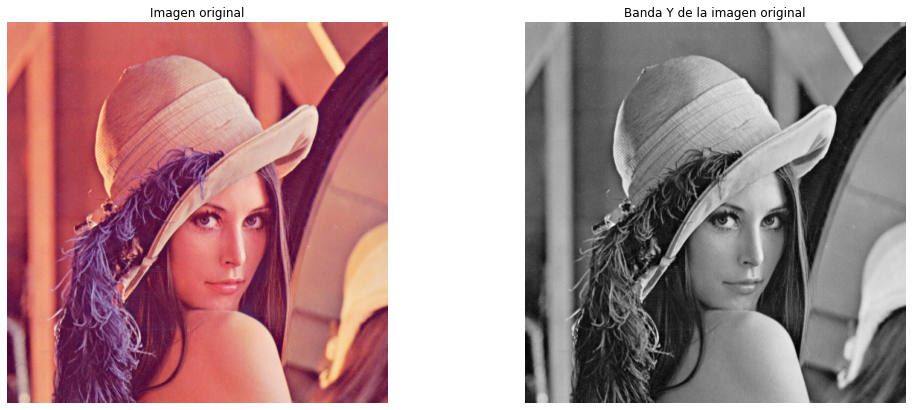

In [4]:
#@title Ingrese imagen desde su equipo: { run: "auto", vertical-output: true }
uploaded = files.upload()

for fn in uploaded.keys():
  name=fn

#Leo la imagen
image = io.imread(name)
image_yiq = rgb_to_yiq(image) #pasar la imagen a espacio yiq

image_y = image_yiq[:,:,0] #utilizar el canal de la luminancia
plot_2images(image/255,'Imagen original', image_y, 'Banda Y de la imagen original')


####1- Pasabajos: Plano y Bartlett 3x3, 5x5, 7x7. Gaussiano 5x5 y 7x7. 

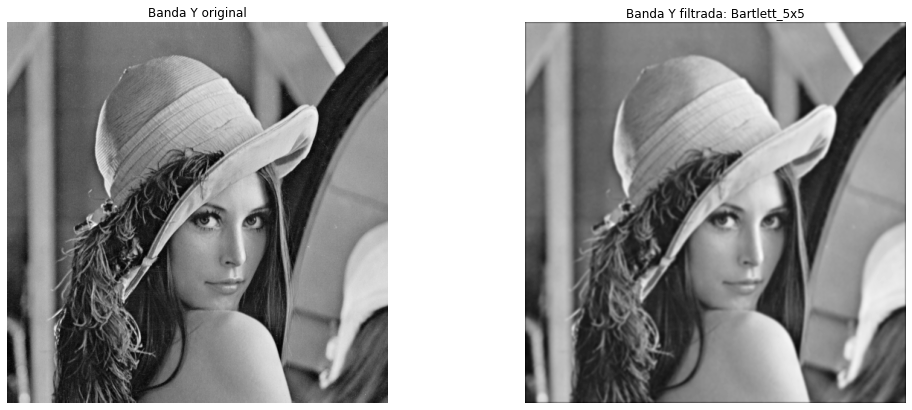

In [5]:
#@title Seleccione el filtro a aplicar: { run: "auto", vertical-output: true }
Filtro_1 = 'Bartlett_5x5' #@param ["Plano_3x3", "Plano_5x5", "Plano_7x7", "Bartlett_3x3", "Bartlett_5x5", "Bartlett_7x7", "Gaussian_5x5", "Gaussian_7x7"]

kernel_dict_1 = {"Plano_3x3":kernel_Plano_3x3, "Plano_5x5":kernel_Plano_5x5, "Plano_7x7":kernel_Plano_7x7, 
            "Bartlett_3x3":kernel_bartlett_3x3, "Bartlett_5x5":kernel_bartlett_5x5, "Bartlett_7x7":kernel_bartlett_7x7,
            "Gaussian_5x5":kernel_gaussian_5x5, "Gaussian_7x7":kernel_gaussian_7x7}

kernel_1 = kernel_dict_1[Filtro_1]

image_conv_1 = _convolution(image_y,kernel_1)

plot_2images(image_y,'Banda Y original', image_conv_1, 'Banda Y filtrada: '+Filtro_1)
# print(image_y.shape)
# print(image_conv_1.shape)

####2- Detectores de bordes: Laplaciano v4 y v8. Sobel las 8 orientaciones.

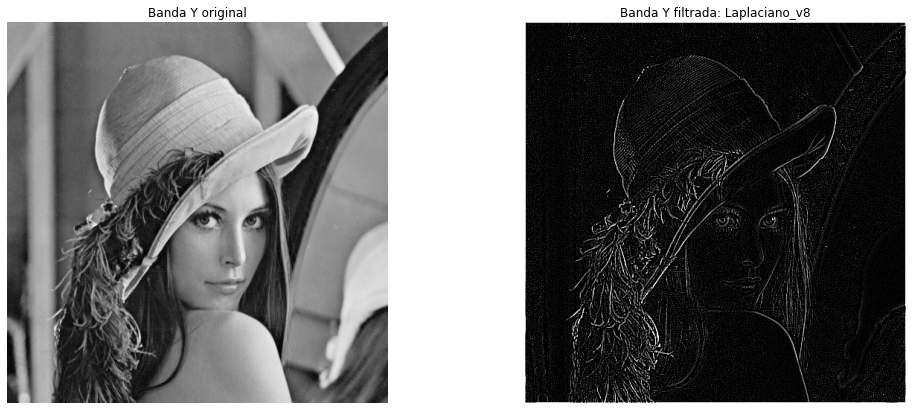

In [6]:
#@title Seleccione el filtro a aplicar: { run: "auto", vertical-output: true }
Filtro_2 = 'Laplaciano_v8' #@param ["Laplaciano_v4", "Laplaciano_v8", "Sobel_N", "Sobel_S", "Sobel_E", "Sobel_O", "Sobel_NE", "Sobel_NO", "Sobel_SE", "Sobel_SO"]

kernel_dict_2 = {"Laplaciano_v4":kernel_laplaciano_v4, "Laplaciano_v8":kernel_laplaciano_v8,
              "Sobel_N":kernel_sobel_N, "Sobel_S":kernel_sobel_S, "Sobel_E":kernel_sobel_E, "Sobel_O":kernel_sobel_O, 
              "Sobel_NE":kernel_sobel_NE, "Sobel_NO":kernel_sobel_NO, "Sobel_SE":kernel_sobel_SE, "Sobel_SO":kernel_sobel_SO}

kernel_2 = kernel_dict_2[Filtro_2]

image_conv_2 = _convolution(image_y,kernel_2)
plot_2images(image_y,'Banda Y original', image_conv_2, 'Banda Y filtrada: '+Filtro_2)
# print(image_y.shape)
# print(image_conv_2.shape)

####3- Pasabanda, pasaaltos de frecuencia de corte 0,2 y 0,4.

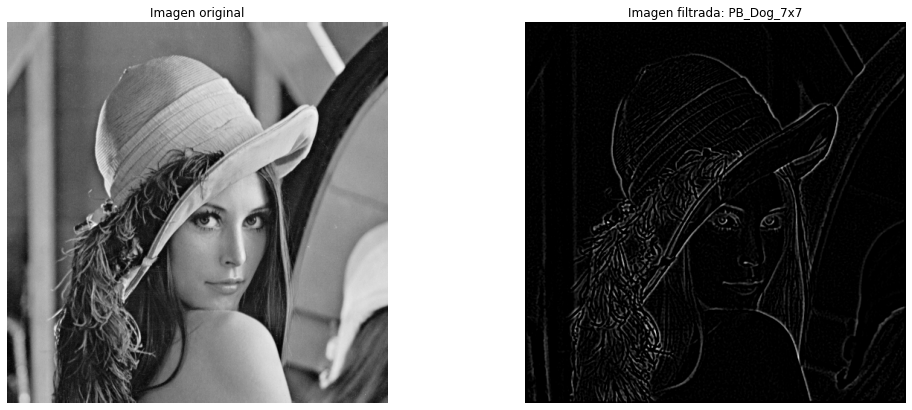

In [13]:
#@title Seleccione el filtro a aplicar: { run: "auto", vertical-output: true }
Filtro_3 = 'PB_Dog_7x7' #@param ["PB_Dog_5x5","PB_Dog_7x7"]

frec_dic={"PB_Dog_5x5":kernel_dog_5x5,"PB_Dog_7x7":kernel_dog_7x7 }

kernel_3 = frec_dic[Filtro_3]

image_conv_3 = _convolution(image_y,kernel_3)

plot_2images(image_y,'Imagen original', image_conv_3, 'Imagen filtrada: '+Filtro_3)
# print(image_y.shape)
# print(image_conv_3.shape)

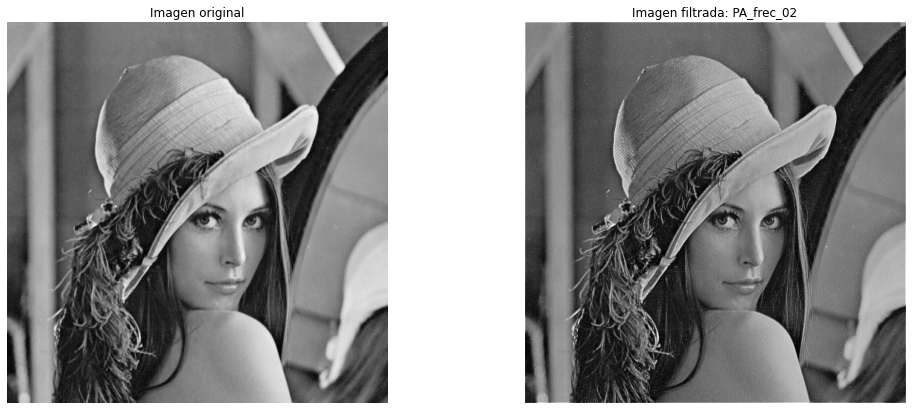

In [10]:
#@title Seleccione el filtro a aplicar: { run: "auto", vertical-output: true }
Filtro_4 = 'PA_frec_02' #@param ["PA_frec_02", "PA_frec_04"]

frec_dic={"PA_frec_02":0.2, "PA_frec_04":0.4}

frec=frec_dic[Filtro_4]
kernel_4 = kernel_laplaciano_v8

image_conv = _convolution(image_y,kernel_4)*frec
image_conv_4 = image_y+image_conv

plot_2images(image_y,'Imagen original', image_conv_4, 'Imagen filtrada: '+Filtro_4)
# print(image_y.shape)
# print(image_conv_4.shape)

#Conclusion:
Los filtros son operaciones que se aplican a los píxeles de una imagen para optimizarla, enfatizar cierta información o conseguir un
efecto especial en ella.

Los principales objetivos que se persiguen con la aplicación de filtros son:

* Suavizar la imagen: reducir la cantidad de variaciones de intensidad entre píxeles vecinos.

* Eliminar ruido: eliminar aquellos píxeles cuyo nivel de intensidad es muy diferente al de sus vecinos y cuyo origen puede estar tanto en el proceso de adquisición de la imagen como en el de transmisión.

* Realzar bordes: destacar los bordes que se localizan en una imagen.

* Detectar bordes: detectar los píxeles donde se produce un cambio brusco en la función intensidad



